In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from itertools import product

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
df = pd.read_excel('dataset/Data 1.xlsx', names=['comment', 'polarity'])
df.shape

(152, 2)

In [3]:
df.head()

,comment,polarity
0,min bnyk yg kecewa lo dgn update terbaru alih ...,1
1,user id password mesti ke bank ya gpplah yg pe...,1
2,saat transfer kadang ada muncul keterangan kon...,1
3,begitu saya update dan no tlpn saya statusnya ...,1
4,tolong tambahkan fitur fingerprint atau face r...,1


## Preprocessing

<ol>
    <li>Case folding <b>(done at previous notebook)</b></li>
    <li>Cleansing <b>(done at previous notebook)</b></li>
    <li>Formalization</li>
    <li>Stemming</li>
    <li>Stopword Removal</li>
    <li>Tokenizing</li>
</ol>
    

### Formalization (Manual)

In [4]:
formal_dict = {}
with open('resources/formalization_dict.txt', 'r') as file:
    i = 1
    for row in file:
        old, new = row.split('\t')
        i += 1
        formal_dict[old] = new.lower().strip()

print(f'There are {len(formal_dict)} token pairs')

There are 51 token pairs


In [5]:
formal_comment = []

for comment in df.comment:
    sentence = ' '+comment+' '
    for false_word, true_word in formal_dict.items():
        word = ' '+false_word+' '
        sentence = sentence.replace(word, ' '+true_word+' ')
    formal_comment.append(sentence)
    
print(f'We have {len(formal_comment)} comments')

We have 152 comments


### Stemming (Sastrawi)

In [6]:
stemmer = StemmerFactory().create_stemmer()
comment_stemmed = [stemmer.stem(formal_comment[i]) for i in range(df.shape[0])]

comment_stemmed[0]

'min bnyk yang kecewa lo dengan update baru alih alih sempurna malah susah nasabah mandiri masuk saya agar kurang tindak tipu jahat waktu ada transaksi yang lebih rb rp maka bisa di tambah security upa kirim nomor verifikasi yang kirim ke nomor hp sms banking trus harus di masuk dalam applikasi mandiri online agar benar bahwa si nasabah sedang laku transaksi dengan demikian pasti tetap aman mohon perhati ya min terimakasih'

In [7]:
formal_comment[0]

' min bnyk yang kecewa lo dengan update terbaru alih alih penyempurnaan malah menyusahkan nasabah mandiri masukan saya agar mengurangi tindak penipuan kejahatan sewaktu ada transaksi yang lebih rb rp maka bisa di tambahkan security berupa pengiriman nomor verifikasi yang dikirimkan ke nomor hp sms banking trus harus di masukkan dalam applikasi mandiri online agar benar bahwa si nasabah sedang melakukan transaksi dengan demikian pasti tetap aman mohon diperhatikan ya min terimakasih '

### Stopwords Removal (Manual)

In [8]:
def remove_token(bad_token, dataset):
    clean_dataset = []
    for comment in dataset:
        comment = ' '+comment+' '
        for token in bad_token:
            word = ' '+token+' '
            comment = comment.replace(word, ' ')
        
        clean_dataset.append(comment.strip())
    
    assert len(dataset) == len(clean_dataset)
    
    return np.array(clean_dataset)

In [9]:
stopwords = [
    'yang', 'untuk', 'pada', 'antara', 'dan' , 'di', 'dari', 'hal', 
    'dalam', 'atau', 'kah', 'pun', 'dsb', 'dst', 'dll', 'toh', 'ya',
    'saya', 'dengan', 'nya', 'ke', 'si', 'dah'
]

print(f'There are {len(stopwords)} stopword list')

There are 23 stopword list


In [10]:
clean_comment = []
for comment in comment_stemmed:
    for token in stopwords:
        word = ' '+token+' '
        comment = comment.replace(word, ' ')
    if sentence.strip():
        clean_comment.append(comment.strip())
        
print(f'We have {len(clean_comment)} comments')

We have 152 comments


In [11]:
clean_comment[0]

'min bnyk kecewa lo update baru alih alih sempurna malah susah nasabah mandiri masuk agar kurang tindak tipu jahat waktu ada transaksi lebih rb rp maka bisa tambah security upa kirim nomor verifikasi kirim nomor hp sms banking trus harus masuk applikasi mandiri online agar benar bahwa nasabah sedang laku transaksi demikian pasti tetap aman mohon perhati min terimakasih'

### Tokenizing

In [12]:
features = np.array([np.array(comment.split()) for comment in clean_comment])
features[:2]

array([array(['min', 'bnyk', 'kecewa', 'lo', 'update', 'baru', 'alih', 'alih',
       'sempurna', 'malah', 'susah', 'nasabah', 'mandiri', 'masuk',
       'agar', 'kurang', 'tindak', 'tipu', 'jahat', 'waktu', 'ada',
       'transaksi', 'lebih', 'rb', 'rp', 'maka', 'bisa', 'tambah',
       'security', 'upa', 'kirim', 'nomor', 'verifikasi', 'kirim',
       'nomor', 'hp', 'sms', 'banking', 'trus', 'harus', 'masuk',
       'applikasi', 'mandiri', 'online', 'agar', 'benar', 'bahwa',
       'nasabah', 'sedang', 'laku', 'transaksi', 'demikian', 'pasti',
       'tetap', 'aman', 'mohon', 'perhati', 'min', 'terimakasih'],
      dtype='<U11'),
       array(['user', 'id', 'password', 'mesti', 'bank', 'gpplah', 'penting',
       'aman', 'transaksi'], dtype='<U9')], dtype=object)

## Modelling

### Random Forest + TF-IDF

<h3>Important</h3>
<ol>
    <li><b>max_df</b>: occurred in too many documents(common word)</li>
    <li><b>min_df</b>: occurred in too few documents (typo, alay)</li>
    <li><b>n_estimators</b>: The number of trees in the forest of the model.</li>
    <li><b>criterion</b>: The function to measure the quality of a split.</li>
    <li><b>max_depth</b>: The max_depth parameter specifies the maximum depth of each tree. The default value for max_depth is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class.</li>
    <li><b>min_samples_split</b>: The minimum number of samples required to split an internal leaf node. The default value for this parameter is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification.</li>
    <li><b>min_samples_leaf</b>: The minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.</li>
    <li><b>max_samples</b>: The number of samples to draw from X to train each base estimator. If None (default), then draw X.shape[0] samples.</li>
</ol>

In [19]:
min_df = [0.0, .1, .2, .3]
max_df = [.5, .6, .7 , .8, .9, 1.0]
n_estimators = [10, 50, 100, 200]
criterion = ['gini', 'entropy']
max_depth = [20, 50, 100, None]
min_samples_split = [2, 5, 10, .1]
min_samples_leaf = [1, 5, 10]
max_samples = [None, .6, .8]

param_combinations = list(product(min_df, max_df, n_estimators, criterion,
                                  max_depth, min_samples_split,
                                  min_samples_leaf, max_samples))
len(param_combinations)

27648

In [21]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []
j=0

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    print(f'==============={i}===============')
    
    for param in param_combinations:
        tfidf_vectorizer = TfidfVectorizer(min_df=param[0], max_df=param[1])
        train_features = tfidf_vectorizer.fit_transform(features[train_idx])
        test_features = tfidf_vectorizer.transform(features[test_idx])
        j+=1
        if j%1000==0:
            print(j)
            
        # train and evaluate
        clf = RandomForestClassifier(n_estimators=param[2], criterion=param[3],
                                     max_depth=param[4], min_samples_split=param[5],
                                     min_samples_leaf=param[6], max_samples=param[7],
                                     random_state=13)
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)
        
print(f'Train and evaluate {len(param_combinations)} permutation of model completed')

===============0===============
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
===============1===============
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
===============2===============
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
===============3===============
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
===============4===============
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136

In [20]:
len(param_combinations)*5

138240

In [22]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [23]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]})'] = train_history[i] 
    eval_history[f'Test Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]})'] = test_history[i]
    
history_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_tfidf

,"Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=0.6)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=0.6)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=0.8)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=0.8)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=None)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=None)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6)",...,"Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=5, min_samples_leaf=5, max_samples=0.6)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=5, min_samples_leaf=5, max_samples=0.6)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=5, min_samples_leaf=5, max_samples=0.8)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=5, min_samples_leaf=5, max_samples=0.8)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=None)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=None)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.6)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.6)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8)"
Batch-1,0.975207,0.838710,0.950413,0.903226,0.975207,0.903226,0.900826,0.806452,0.867769,0.870968,...,0.876033,1.000000,0.884298,1.000000,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000
Batch-2,0.983471,0.870968,0.950413,0.774194,0.975207,0.967742,0.768595,0.645161,0.876033,0.967742,...,0.876033,1.000000,0.884298,1.000000,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000
Batch-3,0.967213,0.866667,0.942623,0.766667,0.967213,0.900000,0.844262,0.733333,0.729508,0.533333,...,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333
Batch-4,0.950820,0.866667,0.901639,0.533333,0.950820,0.833333,0.918033,0.900000,0.770492,0.666667,...,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333
Batch-5,0.975410,0.666667,0.967213,0.633333,0.983607,0.600000,0.959016,0.600000,0.934426,0.633333,...,0.967213,0.633333,0.967213,0.633333,0.967213,0.633333,0.967213,0.633333,0.967213,0.633333
Average,0.970424,0.821935,0.942460,0.722151,0.970411,0.840860,0.878147,0.736989,0.835646,0.734409,...,0.901233,0.900000,0.90453

In [24]:
test_col = [col for col in history_tfidf.columns if col.startswith('Test')]
test_col[history_tfidf.loc['Average', test_col].argmax()]

'Test Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None)'

In [25]:
history_tfidf[['Train Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None)', 'Test Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None)']]

,"Train Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None)","Test Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None)"
Batch-1,0.876033,1.000000
Batch-2,0.876033,1.000000
Batch-3,0.893443,0.933333
Batch-4,0.909836,0.933333
Batch-5,0.967213,0.633333
Average,0.904512,0.900000



We got <b>the best result</b> from Random Forest Model with 
<b>minimum</b> of word's occurrences is <b>30%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>50%</b> of total documents, 
with using <b> tree estimator</b> with <b> function </b>as measurement of quality of split,
<b>max_depth = 1.0</b>, <b>min_samples_split = 1.0</b>, <b>min_samples_leaf = 1.0</b>
and <b>max_samples = scale</b>,
that is: <h3>90.00%</h3>

### Random Forest +  Information Gain + TF-IDF

In [ ]:
min_df = [0.0, .1, .2, .3]
max_df = [.5, .6, .7 , .8, .9, 1.0]
n_estimators = [10, 50, 100, 200]
criterion = ['gini', 'entropy']
max_depth = [20, 50, 100, None]
min_samples_split = [2, 5, 10, .1]
min_samples_leaf = [1, 5, 10]
max_samples = [None, .6, .8]
ig_tresh = [1e-2, 1e-3, 1e-4, 1e-100]

param_combinations = list(product(min_df, max_df, n_estimators, criterion,
                                  max_depth, min_samples_split,
                                  min_samples_leaf, max_samples, ig_tresh))
len(param_combinations)


In [ ]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    ig_res = dict(zip(vectorizer.get_feature_names(),
                      mutual_info_classif(train_count_features, train_labels, discrete_features=True)
                   ))
    ig_res = sorted(ig_res.items(), key=lambda x: x[1], reverse=True)
    print(i)
    
    for param in param_combinations:
        below_tresh = [ig[0] for ig in ig_res if ig[1] < param[-1]]
        new_features = remove_token(below_tresh, features)
        
        tfidf_vectorizer = TfidfVectorizer(min_df=param[0], max_df=param[1])
        train_features = tfidf_vectorizer.fit_transform(new_features[train_idx])
        test_features = tfidf_vectorizer.transform(new_features[test_idx])
        
        # train and evaluate
        clf = RandomForestClassifier(n_estimators=param[2], criterion=param[3],
                                     max_depth=param[4], min_samples_split=param[5],
                                     min_samples_leaf=param[6], max_samples=param[7],
                                     n_jobs=-1, random_state=13)
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)
        
print(f'Train and evaluate {len(param_combinations)} permutation of model completed')

In [ ]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

In [ ]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]}, tresh={param_combinations[i][-1]})'] = train_history[i] 
    eval_history[f'Test Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]}, tresh={param_combinations[i][-1]})'] = test_history[i]
       
history_ig_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_ig_tfidf

In [ ]:
test_col = [col for col in history_ig_tfidf.columns if col.startswith('Test')]
test_col[history_ig_tfidf.loc['Average', test_col].argmax()]


In [115]:
history_ig_tfidf[['Train Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None, tresh=0.0001)', 'Test Acc (min_df=0.1, max_df=0.5, n_estimators=50, criterion=gini, max_depth=20, min_samples_split=10, min_samples_leaf=10, max_samples=None, tresh=0.0001)']]

,"Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, kernel=poly, C=1.0, degree=2, gamma=scale, tresh=0.01)","Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, kernel=poly, C=1.0, degree=2, gamma=scale, tresh=0.01)"
Batch-1,0.867769,1.000000
Batch-2,0.867769,1.000000
Batch-3,0.885246,0.933333
Batch-4,0.885246,0.933333
Batch-5,0.967213,0.600000
Average,0.894648,0.893333


We got <b>the best result</b> from Random Forest Model with 
<b>information gain</b> as feature selection with <b>treshold = 0.0001</b>,
and another parameter from TF-IDF such as 
<b>minimum</b> of word's occurrences is <b>10%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>50%</b> of total documents, 
with using <b>50 tree estimator</b> with <b>gini as a function </b>that measure quality of split,
<b>max_depth = 20</b>, <b>min_samples_split = 10</b>, <b>min_samples_leaf = 10</b>
and <b>max_samples = None</b>,
that is: <h3>90.00%</h3>

### Random Forest +  Chi Square + TF-IDF

In [147]:
min_df = [0.0, .1, .2, .3]
max_df = [.5, .6, .7 , .8, .9, 1.0]
n_estimators = [10, 50, 100, 200]
criterion = ['gini', 'entropy']
max_depth = [20, 50, 100, None]
min_samples_split = [2, 5, 10, .1]
min_samples_leaf = [1, 5, 10]
max_samples = [None, .6, .8]
confidence_interval_list = [0.0, .6, .7, .8, .9, .95]

param_combinations = list(product(min_df, max_df, n_estimators, criterion,
                                  max_depth, min_samples_split,
                                  min_samples_leaf, max_samples,
                                  confidence_interval_list))
len(param_combinations)


[((1, 1), 0.0, 0.5, 'linear', 0.001, 0.0),
 ((1, 1), 0.0, 0.5, 'linear', 0.001, 0.6),
 ((1, 1), 0.0, 0.5, 'linear', 0.001, 0.7)]

In [148]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    chi2_val, p_val = chi2(train_count_features, train_labels)
    chi2_res = list(zip(vectorizer.get_feature_names(), chi2_val, p_val))
    print(i)
    
    for param in param_combinations:
        # if p-value > alpha, then accept H0 (independent)
        alpha = 1.0 - param[-1]
        below_tresh = [word[0] for word in chi2_res if word[2] > alpha]
        new_features = remove_token(below_tresh, features)
        
        tfidf_vectorizer = TfidfVectorizer(min_df=param[0], max_df=param[1])
        train_features = tfidf_vectorizer.fit_transform(new_features[train_idx])
        test_features = tfidf_vectorizer.transform(new_features[test_idx])
        
        # train and evaluate
        clf = RandomForestClassifier(n_estimators=param[2], criterion=param[3],
                                     max_depth=param[4], min_samples_split=param[5],
                                     min_samples_leaf=param[6], max_samples=param[7],
                                     n_jobs=-1, random_state=13)
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)
        
print(f'Train and evaluate {len(param_combinations)} permutation of model completed')

0
1
2
3
4
Train and evaluate 354240 permutation of model completed


In [149]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [150]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]}, confidence_interval={param_combinations[i][-1]*100}%)'] = train_history[i] 
    eval_history[f'Test Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]}, confidence_interval={param_combinations[i][-1]*100}%)'] = test_history[i]

history_chi2_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                       'Batch-4', 'Batch-5', 'Average'])
history_chi2_tfidf

,"Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.0)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.0)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.6)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.6)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.7)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.7)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.8)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.8)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.9)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, kernel=linear, C=0.001, confidence_interval=0.9)",...,"Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.6)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.6)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.7)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.7)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.8)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.8)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.9)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.9)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.95)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, kernel=rbf, C=1.0, gamma=0.1, confidence_interval=0.95)"
Batch-1,0.553719,0.548387,0.553719,0.548387,0.553719,0.548387,0.553719,0.548387,0.553719,0.548387,...,0.793388,0.935484,0.793388,0.935484,0.793388,0.935484,0.793388,0.935484,0.793388,0.935484
Batch-2,0.553719,0.548387,0.553719,0.548387,0.553719,0.548387,0.553719,0.548387,0.553719,0.548387,...,0.809917,0.870968,0.809917,0.870968,0.809917,0.870968,0.809917,0.870968,0.809917,0.870968
Batch-3,0.557377,0.533333,0.557377,0.533333,0.557377,0.533333,0.557377,0.533333,0.557377,0.533333,...,0.811475,0.933333,0.811475,0.933333,0.811475,0.933333,0.811475,0.933333,0.811475,0.933333
Batch-4,0.549180,0.566667,0.549180,0.566667,0.549180,0.566667,0.549180,0.566667,0.549180,0.566667,...,0.836066,0.833333,0.836066,0.833333,0.836066,0.833333,0.836066,0.833333,0.836066,0.833333
Batch-5,0.549180,0.566667,0.549180,0.566667,0.549180,0.566667,0.549180,0.566667,0.549180,0.566667,...,0.909836,0.566667,0.909836,0.566667,0.909836,0.566667,0.909836,0.566667,0.909836,0.566667
Average,0.552635,0.552688,0.552635,0.552688,0.552635,0.552688,0.552635,0.552688,0.552635,0.552688,...,0.832137,0.827957,0.832137,0.827957,0.832137,0.827957,0.832137,0.827957,0.832137,0.827957


In [60]:
test_col = [col for col in history_chi2_tfidf.columns if col.startswith('Test')]
test_col[history_chi2_tfidf.loc['Average', test_col].argmax()]

'Test Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)'

In [153]:
history_chi2_tfidf[['Train Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)', 'Test Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)']]

,"Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, kernel=poly, C=1.0, degree=2, gamma=scale, confidence_interval=0.0)","Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, kernel=poly, C=1.0, degree=2, gamma=scale, confidence_interval=0.0)"
Batch-1,0.867769,1.000000
Batch-2,0.867769,1.000000
Batch-3,0.885246,0.933333
Batch-4,0.885246,0.933333
Batch-5,0.967213,0.600000
Average,0.894648,0.893333


In [59]:
history_chi2_tfidf[['Train Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)', 'Test Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)']]

,"Train Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=50, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.8, confidence_interval=80.0%)"
Batch-1,0.900826,1.000000
Batch-2,0.900826,1.000000
Batch-3,0.918033,0.933333
Batch-4,0.934426,0.933333
Batch-5,0.975410,0.666667
Average,0.925904,0.906667


We got <b>the best result</b> from Random Forest Model with 
<b>chi-square</b> as feature selection with <b>confidence interval = 80%</b>,
and another parameter from TF-IDF such as 
<b>minimum</b> of word's occurrences is <b>0%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>50%</b> of total documents, 
with using <b>50 tree estimator</b> with <b>entropy as a function </b>that measure quality of split,
<b>max_depth = 20</b>, <b>min_samples_split = 5</b>, <b>min_samples_leaf = 5</b>
and <b>max_samples = 0.8</b>,
that is: <h3>90.67%</h3>

### Random Forest +  Query Expansion Ranking + TF-IDF

In [26]:

def calculate_qer_score(features, labels):
    """
    When a feature has low score, the diference between the probabilities 
    for the positive and negative classes is high; therefore the feature is 
    more class specifc and more valuable for classifcation process.
    
    score(f) = p(f) + q(f)/ |p(f) - q(f)|
    p(f) = df(+) + .5/ n(+) + 1.0
    q(f) = df(-) +.5/ n(-) + .5
    df(+) --> document of f with positive class
    n(+) ---> total document with positive class
    """

    # create a dataset
    dataset = [*zip(features, labels)]

    # count frequency each class labels
    label_counts = Counter(train_labels)

    # extract all features
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit_transform(features)
    feature_names = count_vectorizer.get_feature_names()

    qer_score = {}
    for word in feature_names:
        doc_freq = {}

        # count frequency each word at certain class labels
        word = ' '+word+' '

        for label in label_counts:
            doc_freq[label] = 0

        for doc in dataset:
            sentence = ' '+doc[0]+' '
            if word in sentence:
                doc_freq[doc[1]] += 1

        pf = (doc_freq[1] + .5) / (label_counts[1] + 1.0)
        qf = (doc_freq[0] + .5) / (label_counts[0] + .5)
        score = (pf + qf) / abs(pf - qf)
        qer_score[word.strip()] = score
        
    return qer_score

In [31]:
min_df = [0.0, .1, .2, .3]
max_df = [.5, .6, .7 , .8, .9, 1.0]
n_estimators = [10, 50, 100, 200]
criterion = ['gini', 'entropy']
max_depth = [20, 50, 100, None]
min_samples_split = [2, 5, 10, .1]
min_samples_leaf = [1, 5, 10]
max_samples = [None, .6, .8]
keep_data = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, 1.]

param_combinations = list(product(min_df, max_df, n_estimators, criterion,
                                  max_depth, min_samples_split,
                                  min_samples_leaf, max_samples,
                                  keep_data))
len(param_combinations)

110592

In [34]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []
j=0

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    train_features = features[train_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    # calculate qer score
    qer_score = calculate_qer_score(train_features, train_labels)
    size_train_features = len(qer_score)
    sorted_qer_score = sorted(qer_score.items(), key=lambda x: x[1])
    print(f'==============={i}===============')
    
    for param in param_combinations:
        # create new features with selected good feature with qer score
        boundary_idx = round(size_train_features * param[-1])
        below_tresh = [word[0] for word in sorted_qer_score[boundary_idx:]]
        new_features = remove_token(below_tresh, features)
        
        tfidf_vectorizer = TfidfVectorizer(min_df=param[0], max_df=param[1])
        train_features = tfidf_vectorizer.fit_transform(new_features[train_idx])
        test_features = tfidf_vectorizer.transform(new_features[test_idx])
        j+=1
        if j%1000==0:
            print(j)
        # train and evaluate
        clf = RandomForestClassifier(n_estimators=param[2], criterion=param[3],
                                     max_depth=param[4], min_samples_split=param[5],
                                     min_samples_leaf=param[6], max_samples=param[7],
                                     n_jobs=, random_state=13)
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)
        
print(f'Train and evaluate {len(param_combinations)} permutation of model completed')

===============0===============
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
===============1===============
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
1

In [33]:
len(param_combinations)*5

552960

In [35]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [36]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]}, keep_data={param_combinations[i][-1]*100}%)'] = train_history[i] 
    eval_history[f'Test Acc (min_df={param_combinations[i][0]}, max_df={param_combinations[i][1]}, n_estimators={param_combinations[i][2]}, criterion={param_combinations[i][3]}, max_depth={param_combinations[i][4]}, min_samples_split={param_combinations[i][6]}, min_samples_leaf={param_combinations[i][6]}, max_samples={param_combinations[i][7]}, keep_data={param_combinations[i][-1]*100}%)'] = test_history[i]
       
    
history_qer = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_qer

,"Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=10.0%)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=10.0%)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=20.0%)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=20.0%)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=30.0%)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=30.0%)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=40.0%)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=None, keep_data=40.0%)","Train Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=0.6, keep_data=10.0%)","Test Acc (min_df=0.0, max_df=0.5, n_estimators=10, criterion=gini, max_depth=20, min_samples_split=1, min_samples_leaf=1, max_samples=0.6, keep_data=10.0%)",...,"Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.6, keep_data=40.0%)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.6, keep_data=40.0%)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=10.0%)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=10.0%)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=20.0%)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=20.0%)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=30.0%)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=30.0%)","Train Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=40.0%)","Test Acc (min_df=0.3, max_df=1.0, n_estimators=200, criterion=entropy, max_depth=None, min_samples_split=10, min_samples_leaf=10, max_samples=0.8, keep_data=40.0%)"
Batch-1,0.966942,0.774194,0.958678,0.806452,0.983471,0.903226,0.950413,0.903226,0.958678,0.838710,...,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000
Batch-2,0.958678,0.967742,0.966942,1.000000,0.958678,1.000000,0.975207,1.000000,0.942149,1.000000,...,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000,0.876033,1.000000
Batch-3,0.959016,0.866667,0.959016,0.833333,0.950820,0.900000,0.959016,0.833333,0.942623,0.866667,...,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333
Batch-4,0.975410,0.866667,0.967213,0.933333,0.983607,0.900000,0.950820,0.866667,0.918033,0.833333,...,0.893443,0.933333,0.893443,0.933333,0.893443,0.933333,0.893

In [37]:
test_col = [col for col in history_qer.columns if col.startswith('Test')]
test_col[history_qer.loc['Average', test_col].argmax()]


'Test Acc (min_df=0.1, max_df=0.5, n_estimators=10, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6, keep_data=20.0%)'

In [38]:
history_qer[['Train Acc (min_df=0.1, max_df=0.5, n_estimators=10, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6, keep_data=20.0%)', 'Test Acc (min_df=0.1, max_df=0.5, n_estimators=10, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6, keep_data=20.0%)']]

,"Train Acc (min_df=0.1, max_df=0.5, n_estimators=10, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6, keep_data=20.0%)","Test Acc (min_df=0.1, max_df=0.5, n_estimators=10, criterion=entropy, max_depth=20, min_samples_split=5, min_samples_leaf=5, max_samples=0.6, keep_data=20.0%)"
Batch-1,0.892562,0.967742
Batch-2,0.867769,1.000000
Batch-3,0.893443,0.933333
Batch-4,0.885246,0.933333
Batch-5,0.959016,0.666667
Average,0.899607,0.900215


We got <b>the best result</b> from Random Forest Model with <b>Query Expansion Ranking</b> 
as feature selection with we <b>keep 100% of dataset's features</b>,
and another parameter from TF-IDF such as 
<b>minimum</b> of word's occurrences is <b>10%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>50%</b> of total documents, 
with using <b>10 tree estimator</b> with <b>entropy as a function </b>that measure quality of split,
<b>max_depth = 20</b>, <b>min_samples_split = 5</b>, <b>min_samples_leaf = 5</b>
and <b>max_samples = .6</b>,
that is: <h3>90.02%</h3>

In [61]:
models = ['RF + TF-IDF', 'RF + IG + TF-IDF', 
          'RF + CHI2 + TF-IDF', 'RF + QER + TF-IDF']
test_accuracy_avg = [90.00, 90.00, 90.67, 90.02]

res_df = pd.DataFrame({'Model + Feature Selection': models, 'Test Accuracy': test_accuracy_avg})
res_df

,Model + Feature Selection,Test Accuracy
0,RF + TF-IDF,90.00
1,RF + IG + TF-IDF,90.00
2,RF + CHI2 + TF-IDF,90.67
3,RF + QER + TF-IDF,90.02


(80, 95)

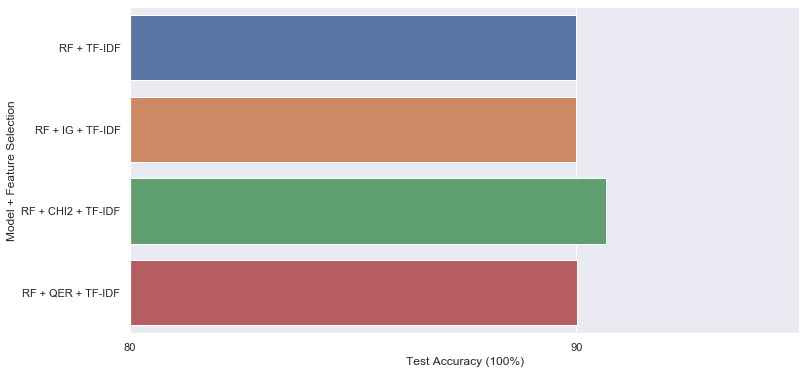

In [63]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12, 6)})

ax = sns.barplot(x='Test Accuracy', y='Model + Feature Selection', data=res_df)
ax.set_xlabel('Test Accuracy (100%)')
plt.xticks([i*10 for i in range(11)])
plt.xlim([80, 95])

## Final Result

In [64]:
models = ['Naive Bayes', 'KNN', 'SVM',
          'Maximum Entropy', 'Random Forest']
test_accuracy_avg = [89.03, 90.00, 90.00, 84.84, 90.67]

final_res_df = pd.DataFrame({'Model': models, 'Test Accuracy': test_accuracy_avg})
final_res_df

,Model,Test Accuracy
0,Naive Bayes,89.03
1,KNN,90.00
2,SVM,90.00
3,Maximum Entropy,84.84
4,Random Forest,90.67


(70, 95)

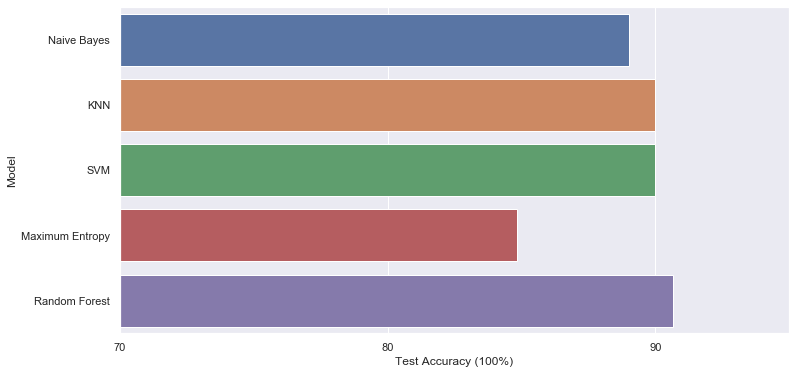

In [65]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12, 6)})

ax = sns.barplot(x='Test Accuracy', y='Model', data=final_res_df)
ax.set_xlabel('Test Accuracy (100%)')
plt.xticks([i*10 for i in range(11)])
plt.xlim([70, 95])